In [603]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

#import tensorflow as tf
#from tensorflow.keras import models, layers, optimizers, metrics
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [177]:
sns.set()

# Get the Data

In [2]:
path = "../raw_data/"

In [3]:
teste = os.path.join(path, "item_categories.csv")
teste

'../raw_data/item_categories.csv'

In [4]:
categories_ = pd.read_csv(os.path.join(path, "item_categories.csv"))
items_ = pd.read_csv(os.path.join(path, "items.csv"))
sales_ = pd.read_csv(os.path.join(path, "sales_train.csv"))
shops_ = pd.read_csv(os.path.join(path, "shops.csv"))
test_ = pd.read_csv(os.path.join(path, "test.csv"))
sample_ = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [5]:
categories_df = categories_.copy()
items_df = items_.copy()
shops_df = shops_.copy()
sales_df = sales_.copy()
test_df = test_.copy()
sample_df = sample_.copy()

In [6]:
sales_df["date"] = pd.to_datetime(sales_df.date, dayfirst=True)
sales_df = sales_df.merge(items_df[['item_id', 'item_category_id']], on='item_id')
sales_df['item_cnt_day'] = sales_df['item_cnt_day'].astype('int8')
sales_df['date_block_num'] = sales_df['date_block_num'].astype('int8')
sales_df['item_price'] = sales_df['item_price'].astype('float16')
sales_df.sort_values("date", inplace=True)

In [7]:
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
400417,2013-01-01,0,51,6622,347.00,1,30
130157,2013-01-01,0,7,1524,3000.00,1,29
867737,2013-01-01,0,19,18721,149.00,1,40
1004082,2013-01-01,0,54,15133,170.00,1,67
1004086,2013-01-01,0,41,15133,170.00,1,67
...,...,...,...,...,...,...,...
1788495,2015-10-31,33,58,3734,3400.00,1,23
2715396,2015-10-31,33,58,17748,288.25,1,70
1502745,2015-10-31,33,26,20949,5.00,3,71
2931438,2015-10-31,33,46,7223,4000.00,1,20


In [209]:
sales_df.dtypes

date                datetime64[ns]
date_block_num                int8
shop_id                      int64
item_id                      int64
item_price                 float16
item_cnt_day                  int8
item_category_id             int64
dtype: object

# Sorting the Data

## Group by Shop

### Sales Count per Week

In [80]:
shops_sales_per_week = pd.DataFrame()
shops_count_sales_per_week_dict = {}
shops_total_sales_per_week_dict = {}

for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].resample('W', on="date").sum()[["item_cnt_day"]]
    df.rename(columns = {'item_cnt_day':shop_id}, inplace=True)
    shops_count_sales_per_week_dict[shop_id] = df.shape[0]
    shops_total_sales_per_week_dict[shop_id] = df[[shop_id]].sum()[0]
    shops_sales_per_week = pd.concat([shops_sales_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
shops_sales_per_week

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,1056.0,586.0,411,222,641,NaN,820,799,586.0,NaN,...,967,755.0,488,627,3126.0,NaN,1146,NaN,NaN,589
2013-01-13,1268.0,598.0,312,212,485,NaN,798,549,309.0,NaN,...,799,595.0,367,513,2157.0,NaN,780,NaN,NaN,411
2013-01-20,1305.0,678.0,281,124,458,NaN,830,469,264.0,NaN,...,667,546.0,401,400,1669.0,NaN,526,NaN,NaN,429
2013-01-27,1258.0,694.0,142,146,348,NaN,821,480,243.0,NaN,...,725,600.0,330,349,1762.0,NaN,547,NaN,NaN,432
2013-02-03,1436.0,817.0,0,175,426,NaN,833,448,252.0,NaN,...,599,533.0,374,423,1885.0,NaN,555,NaN,NaN,374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,168,217,201,237.0,388,268,NaN,3187.0,...,200,14.0,195,258,NaN,854.0,281,456.0,336.0,148
2015-10-11,NaN,NaN,153,157,211,244.0,339,225,NaN,0.0,...,188,NaN,180,257,NaN,366.0,353,541.0,309.0,151
2015-10-18,NaN,NaN,178,146,186,257.0,487,323,NaN,-1.0,...,232,NaN,212,243,NaN,466.0,249,527.0,307.0,170


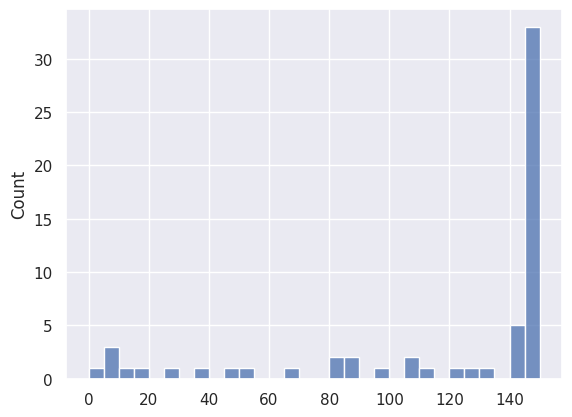

In [180]:
sns.histplot(shops_count_sales_per_week_dict, binwidth=5, binrange=(0, 148));

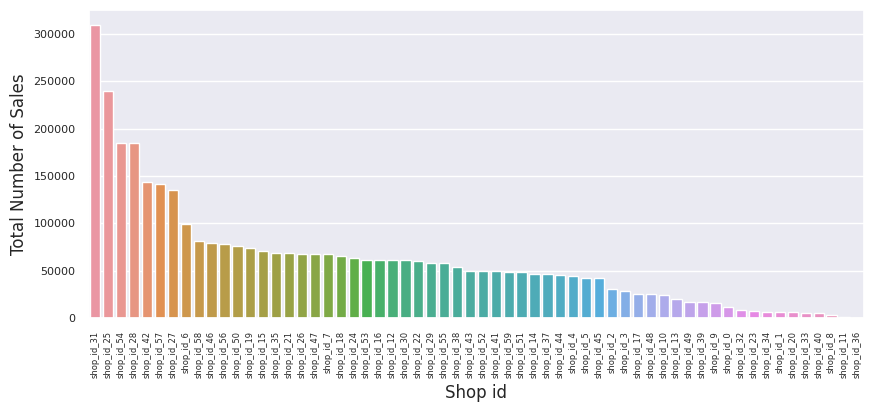

In [181]:
shops_total_sales_per_week_df = pd.DataFrame(shops_total_sales_per_week_dict, index=[0])
shops_total_sales_per_week_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(shops_total_sales_per_week_df)
plt.xlabel("Shop id")
plt.ylabel("Total Number of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

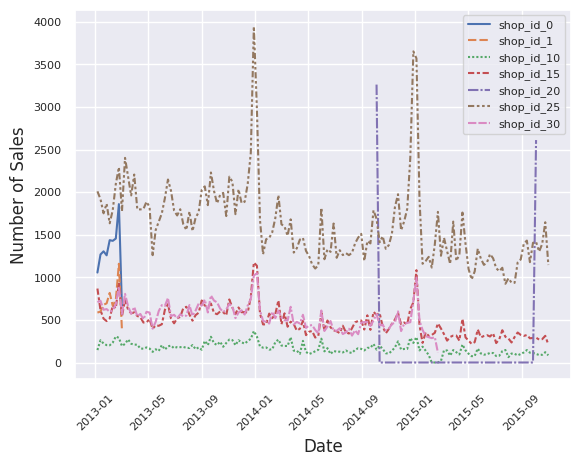

In [182]:
sns.lineplot(data=[
    shops_sales_per_week.shop_id_0,
    shops_sales_per_week.shop_id_1,
    shops_sales_per_week.shop_id_10,
    shops_sales_per_week.shop_id_15,
    shops_sales_per_week.shop_id_20,
    shops_sales_per_week.shop_id_25,
    shops_sales_per_week.shop_id_30
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

### Sales Values per Week

In [96]:
shops_values_per_week = pd.DataFrame()
shops_total_values_per_week_dict = {}

for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].resample('W', on="date").sum()[["item_price"]]
    df.rename(columns = {'item_price':shop_id}, inplace=True)
    shops_total_values_per_week_dict[shop_id] = df[[shop_id]].sum()[0]
    shops_values_per_week = pd.concat([shops_values_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
shops_values_per_week

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,541141.0,306571.0,339015.5000,163664.50,394066.00000,NaN,538795.1250,519415.375,377135.0,NaN,...,701772.0625,262656.0,321967.1875,393540.0,1.753411e+06,NaN,631323.5000,NaN,NaN,471726.5625
2013-01-13,603629.0,267480.0,287780.8750,156213.00,331071.62500,NaN,617301.1875,406003.000,169523.0,NaN,...,594615.5000,234896.0,221581.0000,309680.0,1.245886e+06,NaN,509281.8125,NaN,NaN,318045.5000
2013-01-20,525870.0,319326.0,276500.8125,96326.50,293773.00000,NaN,552376.2500,300023.625,175855.0,NaN,...,605724.0000,150807.0,298933.5000,321255.5,9.543516e+05,NaN,286361.5000,NaN,NaN,352183.0000
2013-01-27,485367.0,288008.0,125619.5000,83605.00,205303.50000,NaN,515650.2500,337844.000,146889.5,NaN,...,543594.0000,179399.0,197321.5000,266209.5,8.723958e+05,NaN,305930.4375,NaN,NaN,246370.4375
2013-02-03,749832.0,386438.0,0.0000,137310.25,267520.50000,NaN,475438.7500,320157.750,130795.0,NaN,...,434565.0000,126742.0,191751.0000,254176.0,8.948352e+05,NaN,299002.1250,NaN,NaN,249678.6250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,255602.2500,237386.00,158169.25000,225973.500,407424.0000,373911.000,NaN,1249850.0,...,293483.0000,15839.0,306469.0000,347241.0,NaN,272515.0,281515.0000,395904.0,434161.96875,169202.0000
2015-10-11,NaN,NaN,225907.0000,154506.00,137015.90625,210525.625,358108.0000,229201.000,NaN,0.0,...,315684.5000,NaN,151875.0000,268835.0,NaN,218647.0,349021.0000,537966.0,357558.00000,142764.0000
2015-10-18,NaN,NaN,217150.0000,114717.50,123172.00000,248638.500,499052.5000,404496.875,NaN,3800.0,...,197641.0000,NaN,195599.5000,172841.0,NaN,276257.0,329935.0000,442278.0,370708.00000,166274.0000


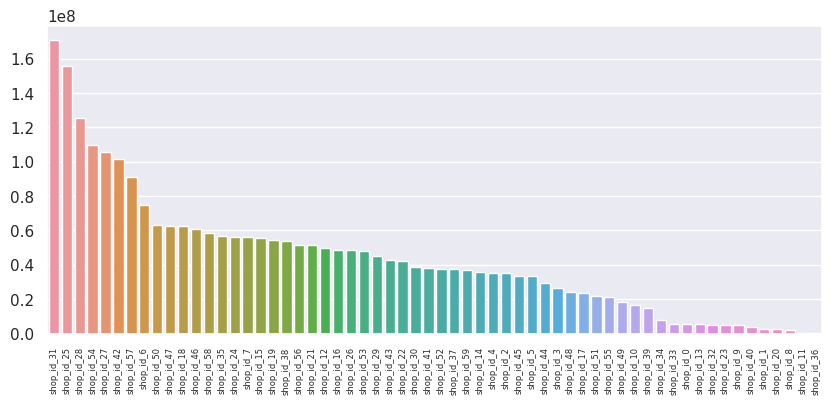

In [183]:
shops_values_per_week_df = pd.DataFrame(shops_total_values_per_week_dict, index=[0])
shops_values_per_week_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(shops_values_per_week_df)
#plt.xlabel("Date")
#plt.ylabel("Number of Sells")
plt.tick_params(axis='x', labelsize=6, rotation=90)
#plt.tick_params(axis='y', labelsize=8)

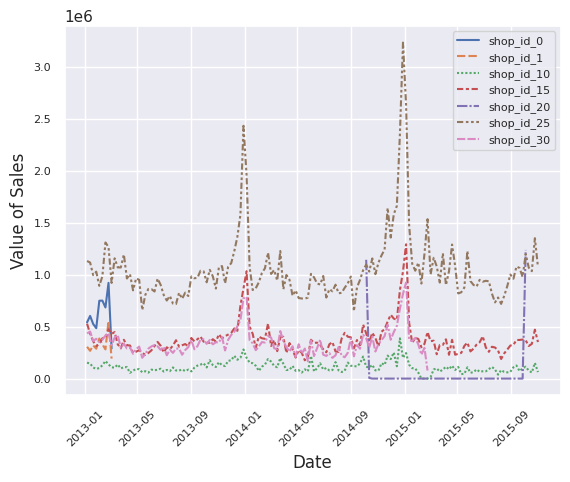

In [184]:
sns.lineplot(data=[
    shops_values_per_week.shop_id_0,
    shops_values_per_week.shop_id_1,
    shops_values_per_week.shop_id_10,
    shops_values_per_week.shop_id_15,
    shops_values_per_week.shop_id_20,
    shops_values_per_week.shop_id_25,
    shops_values_per_week.shop_id_30
])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

## Group by Category

### Sales Count per Week

In [160]:
cats_sales_per_week = pd.DataFrame()
cats_count_sales_per_week_dict = {}
cats_total_sales_per_week_dict = {}

for id in range(categories_df.shape[0]):
    cat_id = f"cat_id_{id}"
    df = sales_df[sales_df['item_category_id'] == id].resample('W', on="date").sum()[["item_cnt_day"]]
    df.rename(columns = {'item_cnt_day':cat_id}, inplace=True)
    cats_count_sales_per_week_dict[cat_id] = df.shape[0]
    cats_total_sales_per_week_dict[cat_id] = df[[cat_id]].sum()[0]
    cats_sales_per_week = pd.concat([cats_sales_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
cats_sales_per_week

,cat_id_0,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,...,cat_id_74,cat_id_75,cat_id_76,cat_id_77,cat_id_78,cat_id_79,cat_id_80,cat_id_81,cat_id_82,cat_id_83
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,NaN,NaN,468,144,85.0,233,245,NaN,NaN,NaN,...,NaN,647,NaN,127,NaN,27,NaN,41.0,310.0,319
2013-01-13,1.0,1.0,303,93,30.0,150,206,NaN,NaN,21.0,...,NaN,712,NaN,122,NaN,21,NaN,38.0,325.0,201
2013-01-20,0.0,0.0,276,83,57.0,103,194,NaN,NaN,55.0,...,NaN,724,NaN,94,NaN,13,NaN,36.0,318.0,144
2013-01-27,0.0,0.0,241,87,56.0,99,156,NaN,NaN,34.0,...,NaN,588,NaN,87,NaN,56,NaN,43.0,289.0,164
2013-02-03,0.0,0.0,232,69,50.0,71,145,NaN,NaN,46.0,...,NaN,623,NaN,116,NaN,44,NaN,40.0,275.0,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,23,246,NaN,11,50,57.0,380.0,321.0,...,2.0,325,42.0,0,16.0,145,401.0,NaN,NaN,87
2015-10-11,NaN,NaN,21,239,NaN,8,64,40.0,0.0,81.0,...,1.0,171,40.0,5,10.0,136,NaN,NaN,NaN,73
2015-10-18,NaN,NaN,17,260,NaN,7,46,38.0,-1.0,96.0,...,1.0,169,45.0,3,21.0,119,NaN,NaN,NaN,81


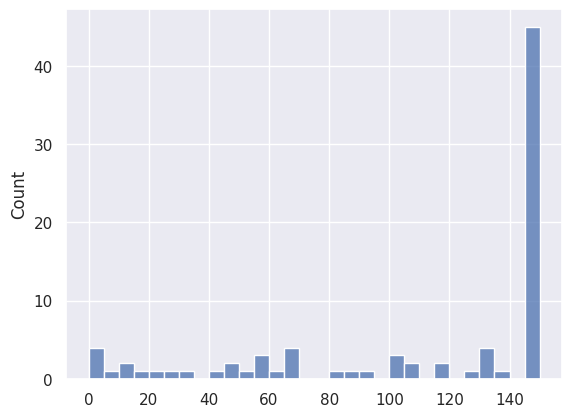

In [185]:
sns.histplot(cats_count_sales_per_week_dict, binwidth=5, binrange=(0, 148));

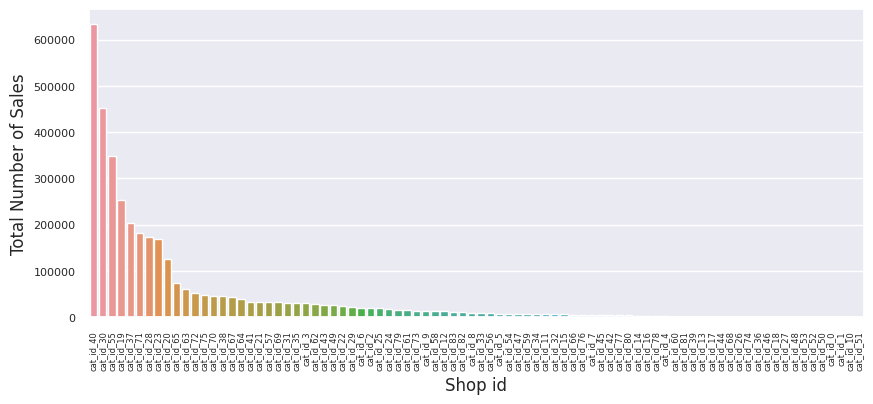

In [186]:
cats_total_sales_per_week_df = pd.DataFrame(cats_total_sales_per_week_dict, index=[0])
cats_total_sales_per_week_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(cats_total_sales_per_week_df)
plt.xlabel("Shop id")
plt.ylabel("Total Number of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

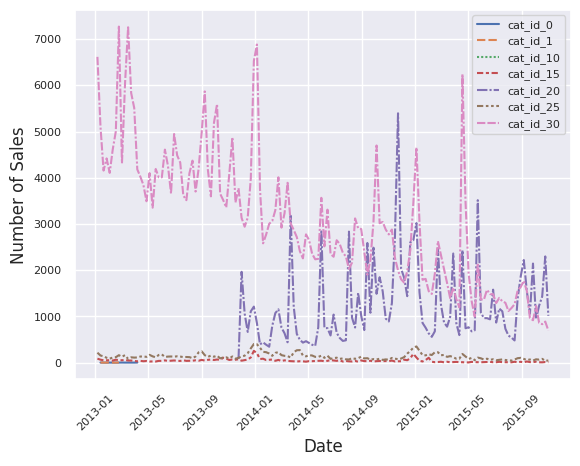

In [187]:
sns.lineplot(data=[
    cats_sales_per_week.cat_id_0,
    cats_sales_per_week.cat_id_1,
    cats_sales_per_week.cat_id_10,
    cats_sales_per_week.cat_id_15,
    cats_sales_per_week.cat_id_20,
    cats_sales_per_week.cat_id_25,
    cats_sales_per_week.cat_id_30
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

### Sales Values per Week

In [151]:
cats_values_per_week = pd.DataFrame()
cats_total_values_per_week_dict = {}

for id in range(categories_df.shape[0]):
    cat_id = f"cat_id_{id}"
    df = sales_df[sales_df['item_category_id'] == id].resample('W', on="date").sum()[["item_price"]]
    df.rename(columns = {'item_price':cat_id}, inplace=True)
    cats_total_values_per_week_dict[cat_id] = df[[cat_id]].sum()[0]
    cats_values_per_week = pd.concat([cats_values_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
cats_values_per_week

,cat_id_0,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,...,cat_id_74,cat_id_75,cat_id_76,cat_id_77,cat_id_78,cat_id_79,cat_id_80,cat_id_81,cat_id_82,cat_id_83
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,NaN,NaN,812946.0,44590.500,75362.0,216865.875,362744.5,NaN,NaN,NaN,...,NaN,881089.5,NaN,24588.000,NaN,10090.000,NaN,7428.0,3877.0,12120.9375
2013-01-13,148.0,148.0,559555.5,36031.750,35179.0,154565.500,287245.5,NaN,NaN,9092.000000,...,NaN,906588.5,NaN,21896.000,NaN,12218.500,NaN,5178.0,4111.0,9728.0000
2013-01-20,0.0,0.0,570507.0,32155.000,46328.0,101045.000,324888.0,NaN,NaN,11144.750000,...,NaN,936847.5,NaN,15153.000,NaN,9060.000,NaN,4564.0,4210.0,6996.3750
2013-01-27,0.0,0.0,514723.0,34371.000,50970.0,98602.250,265928.0,NaN,NaN,11898.000000,...,NaN,843682.0,NaN,13910.125,NaN,7170.000,NaN,6501.0,3602.0,7520.0000
2013-02-03,0.0,0.0,464550.0,25903.000,32788.0,66969.000,211210.0,NaN,NaN,7039.312500,...,NaN,933673.0,NaN,19429.000,NaN,19100.000,NaN,5254.0,3583.0,5509.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,65684.0,506223.000,NaN,7089.000,125921.0,120073.0,24659.0,8939.375000,...,4980.0,241209.0,52559.0,0.000,5177.0,120483.250,190486.0,NaN,NaN,8640.0000
2015-10-11,NaN,NaN,50812.0,469556.375,NaN,4992.000,164193.0,94166.0,0.0,10506.625000,...,3990.0,372272.0,40149.0,1055.000,3248.0,109999.125,NaN,NaN,NaN,5811.0000
2015-10-18,NaN,NaN,54446.0,439855.000,NaN,4393.000,120645.0,103501.0,1500.0,17528.750000,...,3990.0,328070.0,70668.0,657.000,6731.0,78772.875,NaN,NaN,NaN,7445.0000


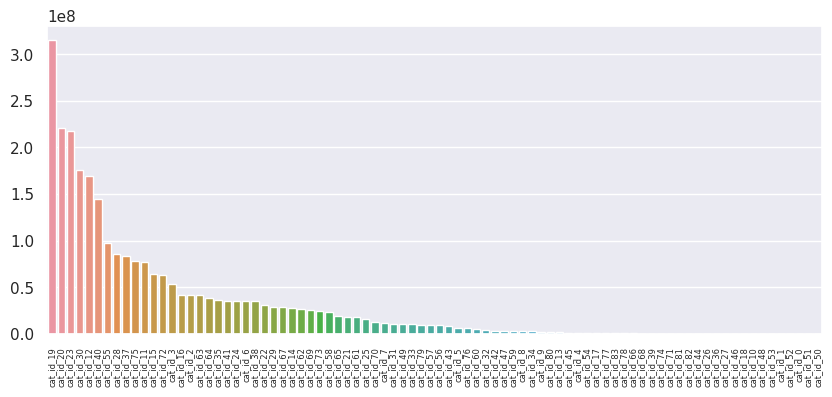

In [188]:
cats_total_values_per_week_df = pd.DataFrame(cats_total_values_per_week_dict, index=[0])
cats_total_values_per_week_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(cats_total_values_per_week_df)
#plt.xlabel("Date")
#plt.ylabel("Number of Sells")
plt.tick_params(axis='x', labelsize=6, rotation=90)
#plt.tick_params(axis='y', labelsize=8)

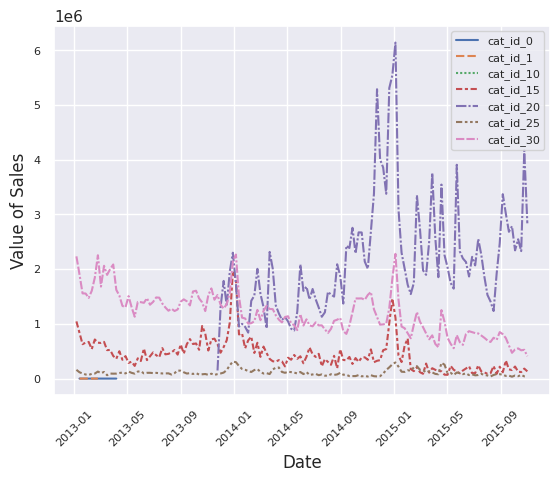

In [189]:
sns.lineplot(data=[
    cats_values_per_week.cat_id_0,
    cats_values_per_week.cat_id_1,
    cats_values_per_week.cat_id_10,
    cats_values_per_week.cat_id_15,
    cats_values_per_week.cat_id_20,
    cats_values_per_week.cat_id_25,
    cats_values_per_week.cat_id_30
])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

## Group by item

### Sales Count per Week

### Sales Values per Week

## Total

In [255]:
total_shops_sales_per_week = shops_sales_per_week.fillna(0).sum(axis=1)
total_shops_values_per_week = shops_values_per_week.fillna(0).sum(axis=1)
total_cats_sales_per_week = cats_sales_per_week.fillna(0).sum(axis=1)
total_cats_values_per_week = cats_values_per_week.fillna(0).sum(axis=1)

In [256]:
total_shops_sales_per_week_df = pd.DataFrame(total_shops_sales_per_week)
total_shops_values_per_week_df = pd.DataFrame(total_shops_values_per_week)
total_cats_sales_per_week_df = pd.DataFrame(total_cats_sales_per_week)
total_cats_values_per_week_df = pd.DataFrame(total_cats_values_per_week)

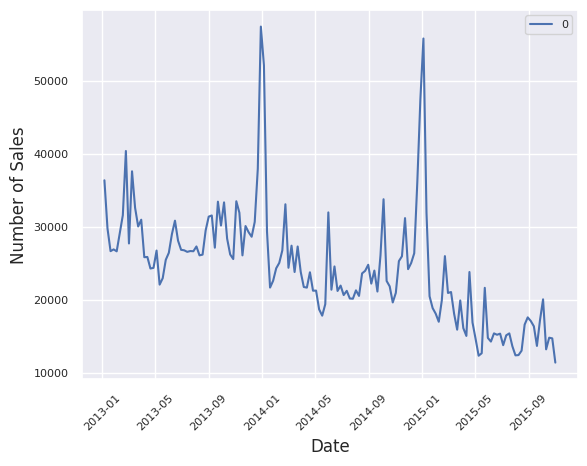

In [257]:
sns.lineplot(data=[
    total_shops_sales_per_week_df[0],
    total_cats_sales_per_week_df[0]
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

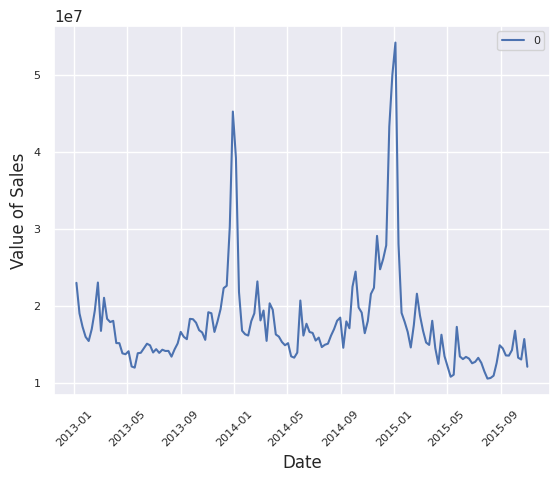

In [258]:
sns.lineplot(data=[
    total_shops_values_per_week_df[0],
    total_cats_values_per_week_df[0]
])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

# Model Prophet

## Model Setup

In [628]:
# plot graph with train test and predict
def plot_forecast(train_df, test_df, forecast, lower=False, upper=False):
    plt.figure(figsize=(15, 8))
    plt.plot(train_df['ds'], train_df['y'], label="Train")
    plt.plot(test_df['ds'], test_df['y'], label="Test")
    plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="Pred")
    if lower:
        plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat_lower'], label="Lower")
    if upper:
        plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat_upper'], label="Upper")
    plt.legend(loc="best")
    plt.show()

In [629]:
# function to split the data between train and test
def set_train_data(df):
    df = df.reset_index()
    df.columns = ['ds', 'y']
    train = df.iloc[:127]
    test = df.iloc[127:]
    return train, test

In [643]:
# rum the Prophet model
def fit_prophet(df, horizon=29, freq='W'):
    train_df, test_df = set_train_data(df)
    
    model = Prophet(
        seasonality_mode='multiplicative', # or 'additive'
        seasonality_prior_scale=5, # default 10, smaller values dampen the seasonality
        interval_width=0.80, # deaful 0.8, if mcmc < 0 will be integrated over all model parameters
        growth='linear', # is the default
        #yearly_seasonality=False, # default 'auto'
        #weekly_seasonality=True, # default 'auto'
        #daily_seasonality=False, # default 'auto'
        mcmc_samples=0, # default 0, if greater than 0, will do full Bayesian inference
    )
    model = model.fit(train_df)
    
    forecast = future_preds(model, horizon, freq)
    
    return model, forecast

In [631]:
# make future predictions
def future_preds(model, horizon=29, freq='W'):
    future = model.make_future_dataframe(periods=horizon, freq=freq, )
    forecast = model.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return forecast    

## Total (Shop / Category)

### Fitting the Data and Making Future Predictions

In [661]:
# total_Shops_Number_sales_per_week
model_tSNw, forecast_tSNw = fit_prophet(total_shops_sales_per_week_df, horizon=29, freq='W')

# total_Shops_Values_per_week
model_tSVw,  forecast_tSVw = fit_prophet(total_shops_values_per_week_df, horizon=29, freq='W')

17:07:42 - cmdstanpy - INFO - Chain [1] start processing
17:07:42 - cmdstanpy - INFO - Chain [1] done processing
17:07:42 - cmdstanpy - INFO - Chain [1] start processing
17:07:42 - cmdstanpy - INFO - Chain [1] done processing


In [662]:
forecast_tSNw[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8)

,ds,yhat,yhat_lower,yhat_upper
148,2015-11-08,20512.918906,16174.762243,24977.838988
149,2015-11-15,22785.799152,18041.152452,27237.531146
150,2015-11-22,21946.092694,17739.925599,26760.508831
151,2015-11-29,18964.053530,14531.354987,23653.355145
152,2015-12-06,17839.977126,13385.523981,22556.538322
153,2015-12-13,21606.466601,17126.868505,26231.442789
154,2015-12-20,28754.426780,23981.574096,33098.672858
155,2015-12-27,33991.824658,29235.363995,38494.020466


In [663]:
forecast_tSVw[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8)

,ds,yhat,yhat_lower,yhat_upper
148,2015-11-08,1.705679e+07,1.364982e+07,2.069611e+07
149,2015-11-15,1.959115e+07,1.603000e+07,2.304589e+07
150,2015-11-22,1.968361e+07,1.604078e+07,2.289766e+07
151,2015-11-29,1.805334e+07,1.455120e+07,2.155245e+07
152,2015-12-06,1.827942e+07,1.510478e+07,2.164599e+07
153,2015-12-13,2.314158e+07,1.962913e+07,2.632283e+07
154,2015-12-20,3.107983e+07,2.764667e+07,3.428008e+07
155,2015-12-27,3.672474e+07,3.332946e+07,4.033887e+07


### Plotting the forecast

#### Shops Total Number of Sales per Week

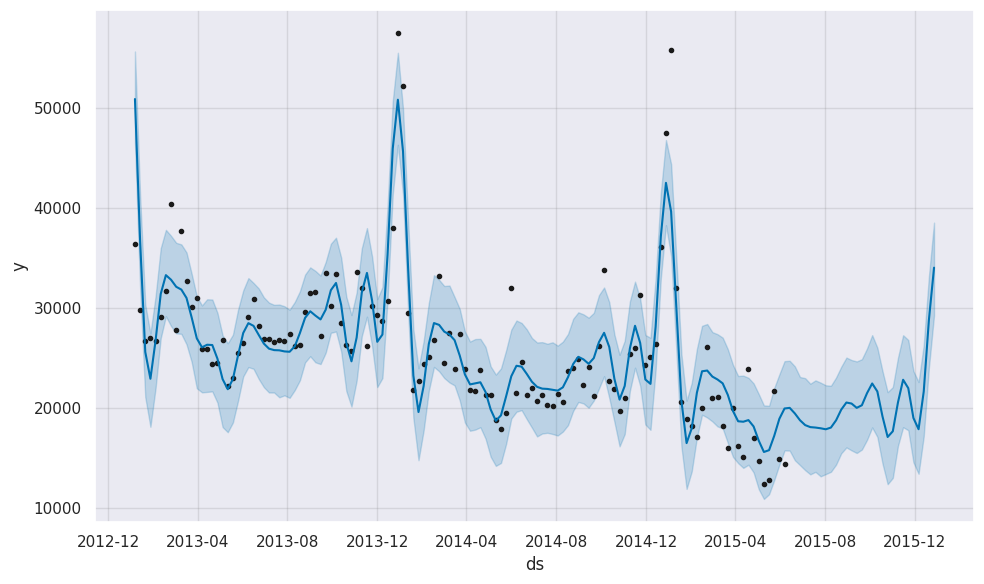

In [664]:
ax_tSNw = model_tSNw.plot(forecast_tSNw);

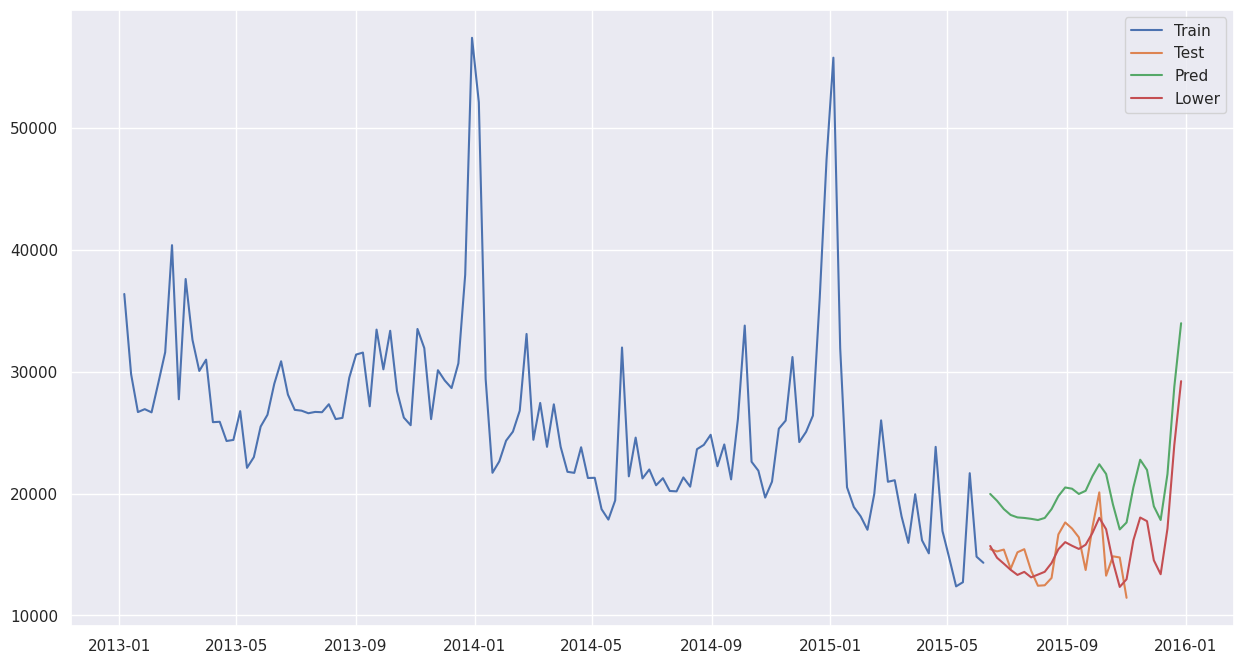

In [665]:
plot_forecast(train_tSNw, test_tSNw, forecast_tSNw, lower=True)

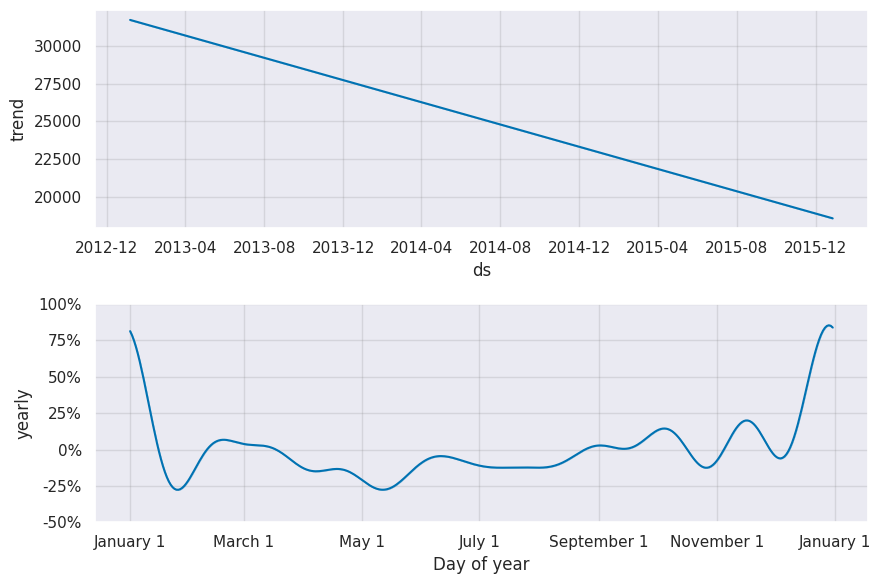

In [666]:
model_tSNw.plot_components(forecast_tSNw);

#### Shops Total Value of Sales per Week

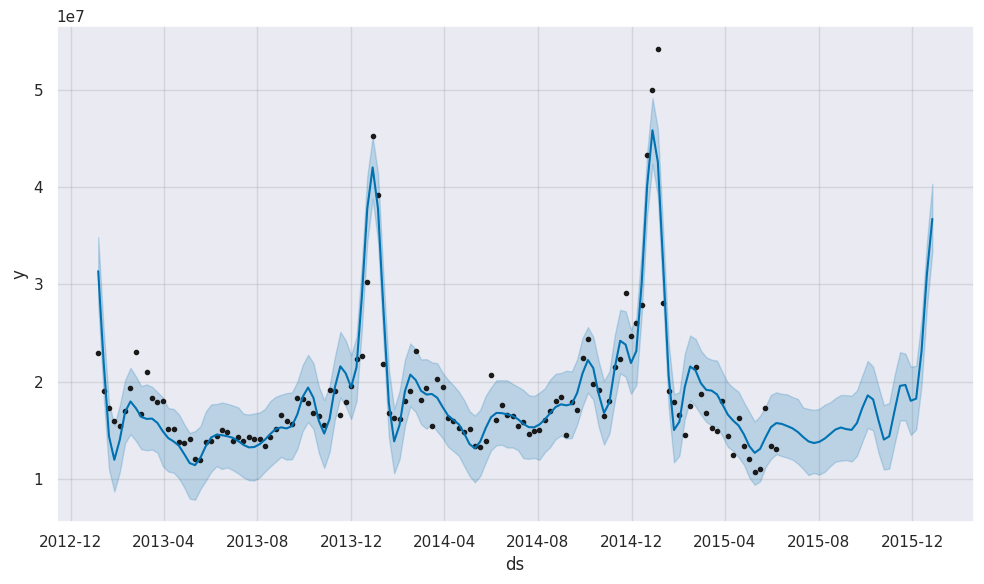

In [667]:
ax_tSVw = model_tSVw.plot(forecast_tSVw);

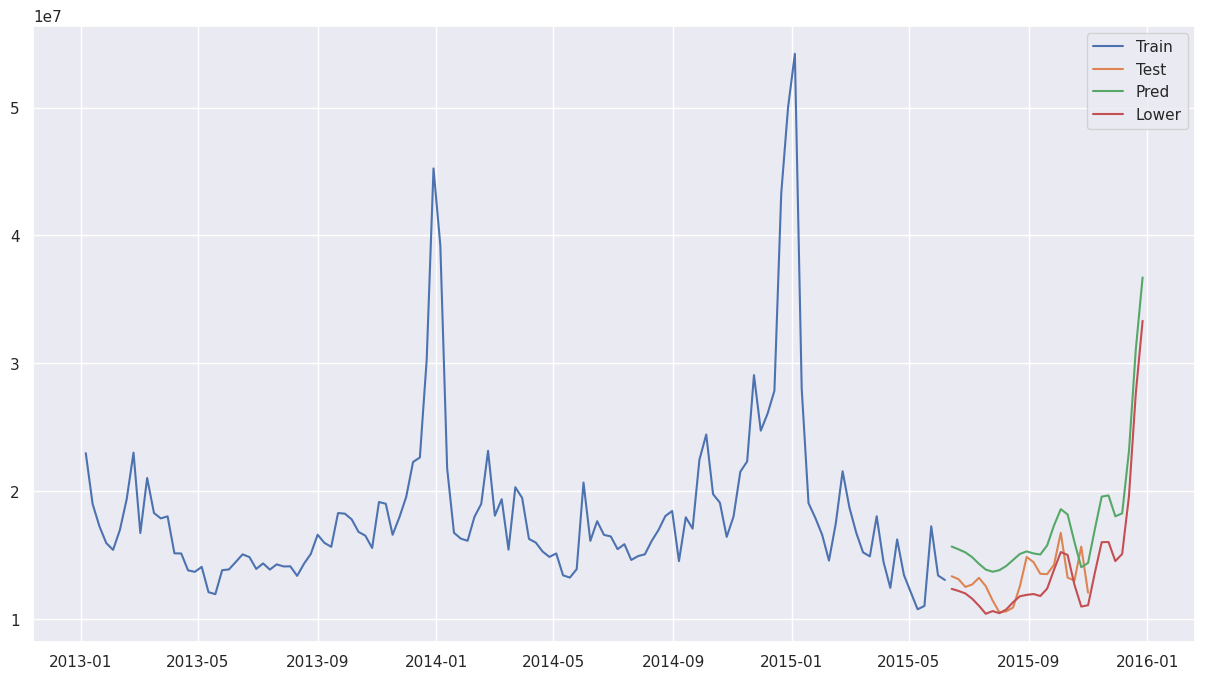

In [668]:
plot_forecast(train_tSVw, test_tSVw, forecast_tSVw, lower=True)

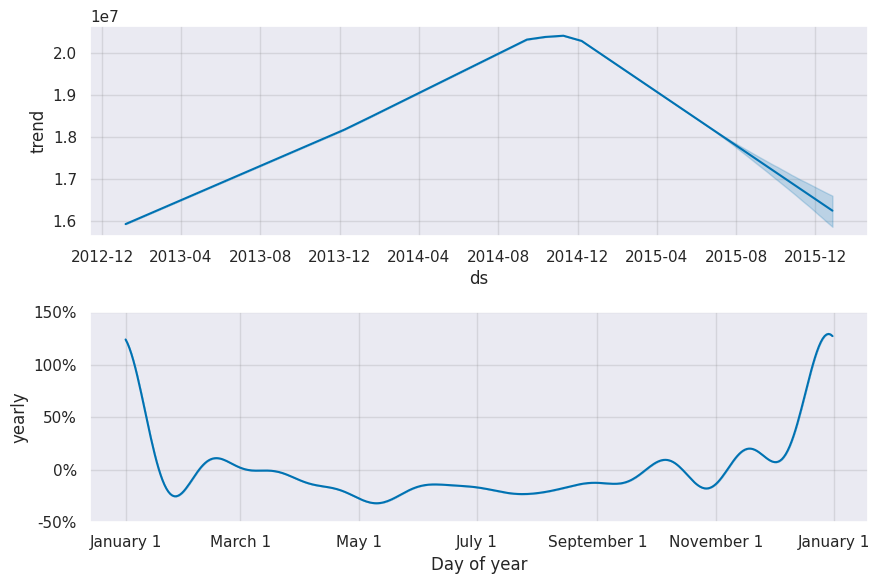

In [669]:
model_tSVw.plot_components(forecast_tSVw);

### Evaluating the model with cross-validation

In [599]:
cv_results = cross_validation(
    model=model_tSNw,
    initial=f'{4 * 7 * 5} days', # five month
    horizon=f'{4 * 7} days', # one month
    period='7 days'
)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/103 [00:00<?, ?it/s]

16:34:03 - cmdstanpy - INFO - Chain [1] start processing
16:34:03 - cmdstanpy - INFO - Chain [1] done processing
16:34:04 - cmdstanpy - INFO - Chain [1] start processing
16:34:04 - cmdstanpy - INFO - Chain [1] done processing
16:34:04 - cmdstanpy - INFO - Chain [1] start processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
16:34:05 - cmdstanpy - INFO - Chain [1] start processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:07 - cmdstanpy - INFO - Chain [1] start processing
16:34:07 - cmdstanpy - INFO - Chain [1] done processing
16:34:07 - cmdstanpy - INFO - Chain [1] start processing
16:34:07 - cmdstanpy - INFO - Chain [1] done processing
16:34:08 - cmdstanpy - INFO - Chain [1] start processing
16:34:08 - cmdstanpy - INFO - Chain [1]

16:35:04 - cmdstanpy - INFO - Chain [1] done processing
16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing
16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing
16:35:09 - cmdstanpy - INFO - Chain [1] start processing
16:35:09 - cmdstanpy - INFO - Chain [1] done processing
16:35:10 - cmdstanpy - INFO - Chain [1] start processing
16:35:10 - cmdstanpy - INFO - Chain [1] done processing
16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing
16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing
16:35:12 - cmdstanpy - INFO - Chain [1] 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-06-02,34943.023964,32109.664223,37863.385222,26476.0,2013-05-26
1,2013-06-09,47756.286416,45066.627257,50682.031923,29021.0,2013-05-26
2,2013-06-16,55573.498965,52626.590512,58450.008613,30869.0,2013-05-26
3,2013-06-23,49456.252688,46363.787748,52146.540613,28135.0,2013-05-26
4,2013-06-09,18430.987202,15521.917064,21559.597510,29021.0,2013-06-02
...,...,...,...,...,...,...
407,2015-05-31,20130.428976,15819.132511,24673.623805,14826.0,2015-05-03
408,2015-05-17,15891.032891,11299.825863,20431.727479,12730.0,2015-05-10
409,2015-05-24,17693.918508,13334.254464,22443.447713,21681.0,2015-05-10
410,2015-05-31,19854.256545,15195.317288,24261.686733,14826.0,2015-05-10


In [600]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-06-02,34943.023964,32109.664223,37863.385222,26476.0,2013-05-26
1,2013-06-09,47756.286416,45066.627257,50682.031923,29021.0,2013-05-26
2,2013-06-16,55573.498965,52626.590512,58450.008613,30869.0,2013-05-26
3,2013-06-23,49456.252688,46363.787748,52146.540613,28135.0,2013-05-26
4,2013-06-09,18430.987202,15521.917064,21559.597510,29021.0,2013-06-02
...,...,...,...,...,...,...
407,2015-05-31,20130.428976,15819.132511,24673.623805,14826.0,2015-05-03
408,2015-05-17,15891.032891,11299.825863,20431.727479,12730.0,2015-05-10
409,2015-05-24,17693.918508,13334.254464,22443.447713,21681.0,2015-05-10
410,2015-05-31,19854.256545,15195.317288,24261.686733,14826.0,2015-05-10


In [601]:
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,3.170203e+08,17805.063653,7098.899210,0.273342,0.147738,0.214932,0.572816
1,14 days,2.170130e+09,46584.658043,15873.599335,0.597537,0.196903,0.373673,0.533981
2,21 days,6.214575e+09,78832.572737,25035.900887,0.928933,0.196623,0.449771,0.475728
3,28 days,9.658324e+09,98276.770597,30012.529944,1.111181,0.201067,0.459062,0.427184


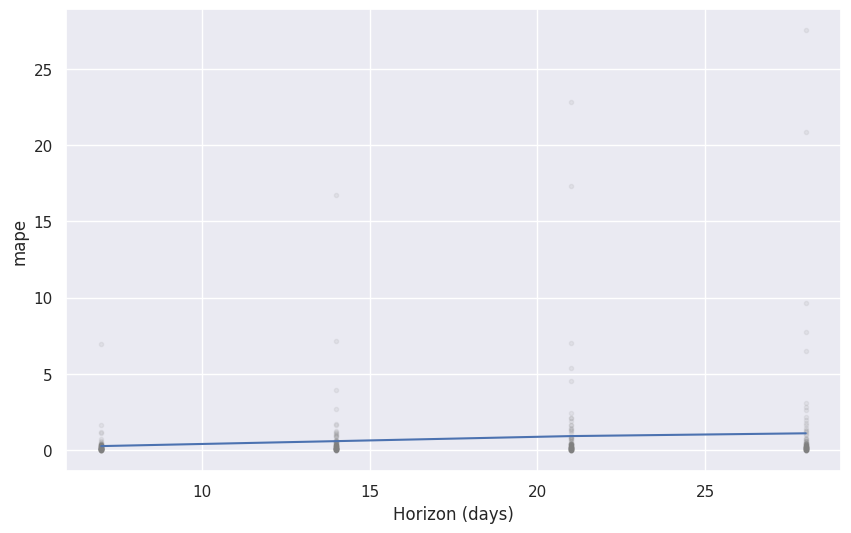

In [604]:
plot_cross_validation_metric(cv_results, metric='mape');

##  Shop

## Category

# Data

In [ ]:
sales_df.sample(10)

In [ ]:
sales_df.describe()

In [ ]:
sales_df.item_cnt_day.nunique()

In [30]:
open_shops = np.sort(test_df['shop_id'].unique())
open_shops

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59])

In [ ]:
test_df.nunique()

In [ ]:
print("Categories:", categories_df.shape)
print("Items:", items_df.shape)
print("Shops:", shops_df.shape)
print("Sales:", sales_df.shape)
print("Test:", test_df.shape)
print("Sample:", sample_df.shape)

In [ ]:
# Total shop * itens, diff with sample
total = items_df.shape[0] * shops_df.shape[0]
print("Total shop * itens:", total)
print("Diffrence with the smple:", total - sample_df.shape[0])

In [ ]:
sales_df.dtypes

In [ ]:
sales_df

In [ ]:
shops_sales_month = pd.pivot_table(
    sales_df, values='item_cnt_day',
    index=['shop_id', 'item_id'], columns=['date_block_num'],
    aggfunc=np.sum 
)
shops_sales_month.fillna(0, inplace=True)
shops_sales_month.reset_index(inplace=True)

In [ ]:
shops_sales_month

In [ ]:
shops_sales_month['final_id'] = shops_sales_month['shop_id'].astype(str) + "-" + shops_sales_month['item_id'].astype(str)
shops_sales_month.set_index('final_id', inplace=True)
shops_sales_month.drop(columns=['shop_id', 'item_id'], inplace=True)
shops_sales_month = shops_sales_month.T

In [ ]:
shops_sales_month

In [ ]:
plot_cols = ['0-32', '0-49', '59-22144', '59-22167']
plot_features = shops_sales_month[plot_cols]
plot_features.index = shops_sales_month.index
plot_features.plot(subplots = True);

## Model

In [ ]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # $CHALLENGIFY_BEGIN
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)
    # $CHALLENGIFY_END

In [ ]:
TARGET = '0-32'

In [ ]:
X_train, y_train = get_Xi_yi(shops_sales_month, 10, 10)

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
def init_model(X_train, y_train):
    
    model = models.Sequential()
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          recurrent_dropout = 0.3))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [ ]:
init_model(X_train, y_train)

# old

In [19]:
sales_df[sales_df['shop_id'] == 10].sort_values("date").groupby(by='date').sum('item_cnt_day')

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2013-01-02,0,300,210640,39714.000000,31,754
2013-01-03,0,280,212329,30688.000000,30,774
2013-01-04,0,280,212896,55033.000000,31,901
2013-01-05,0,340,371753,12901.000000,34,1344
2013-01-06,0,190,118865,14570.000000,20,620
...,...,...,...,...,...,...
2015-10-27,330,100,101015,13028.187500,12,391
2015-10-28,429,130,124608,7615.187500,13,488
2015-10-29,462,140,133988,14871.937500,14,662


In [20]:
shop_sales_month =pd.DataFrame({"date_block_num": range(34)})
type(shop_sales_month)

pandas.core.frame.DataFrame

In [21]:
total_month_dict = {}
for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].groupby(by='date_block_num').sum('item_cnt_day')
    total_month_dict[shop_id] = df.shape[0]
    shop_sales_month[shop_id] = df.item_cnt_day
shop_sales_month.fillna(0, inplace=True)
shop_sales_month.drop(columns=['date_block_num'], inplace=True)

In [22]:
shop_sales_month

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,5578.0,2947.0,1146,767,2114,0.0,3686,2495,1463.0,0.0,...,3406,2748.0,1812,2055,9386.0,0.0,3238,0.0,0.0,2017
1,6127.0,3364.0,488,798,2025,877.0,4007,2513,1156.0,0.0,...,3054,2284.0,1737,1906,8075.0,0.0,2655,0.0,0.0,1897
2,0.0,0.0,753,959,2060,1355.0,4519,2460,977.0,0.0,...,3610,2605.0,2034,2365,9488.0,0.0,3099,6586.0,3773.0,2028
3,0.0,0.0,583,647,285,1008.0,3168,1540,-1.0,0.0,...,2740,1945.0,1446,1515,6726.0,0.0,2153,5493.0,2831.0,1388
4,0.0,0.0,553,710,1211,1110.0,3022,1647,0.0,0.0,...,2839,2243.0,1482,1767,7006.0,852.0,2140,5233.0,2308.0,1374
5,0.0,0.0,832,784,1464,1393.0,3847,2085,0.0,0.0,...,3761,2200.0,1815,2125,8101.0,728.0,3105,5987.0,2972.0,1707
6,0.0,0.0,807,721,1378,1265.0,3360,2031,0.0,0.0,...,3235,2273.0,1616,1975,7225.0,795.0,3294,5827.0,3122.0,1747
7,0.0,0.0,875,890,1713,1510.0,3702,2397,0.0,0.0,...,3718,2142.0,1772,2367,7792.0,719.0,3311,5413.0,2863.0,2048
8,0.0,0.0,945,1026,1536,1298.0,3952,2599,0.0,0.0,...,3655,1903.0,2125,2440,7571.0,812.0,2829,5213.0,2735.0,2008
9,0.0,0.0,795,793,1482,1267.0,3675,2236,0.0,6014.0,...,3525,1809.0,1965,2245,6676.0,916.0,2375,5686.0,3022.0,1751


In [23]:
closed_shops = shop_sales_month.iloc[31:34]
closed_shops = pd.DataFrame(shop_sales_month.iloc[31:34].sum()).T
closed_shops

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,0.0,0.0,2491.0,2024.0,2510.0,3438.0,5102.0,3908.0,0.0,3186.0,...,2936.0,1540.0,2865.0,3608.0,0.0,8511.0,4061.0,7362.0,4503.0,2918.0


In [24]:
pd.DataFrame(shop_sales_month.iloc[31:34].sum()).head(60)

,0
shop_id_0,0.0
shop_id_1,0.0
shop_id_2,2491.0
shop_id_3,2024.0
shop_id_4,2510.0
shop_id_5,3438.0
shop_id_6,5102.0
shop_id_7,3908.0
shop_id_8,0.0
shop_id_9,3186.0


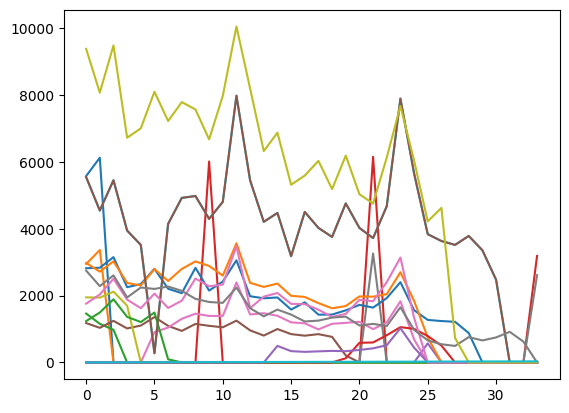

In [25]:
plt.plot(shop_sales_month.shop_id_0)
plt.plot(shop_sales_month.shop_id_1)
plt.plot(shop_sales_month.shop_id_8)
plt.plot(shop_sales_month.shop_id_9)

plt.plot(shop_sales_month.shop_id_11)
plt.plot(shop_sales_month.shop_id_13)
plt.plot(shop_sales_month.shop_id_17)
plt.plot(shop_sales_month.shop_id_20)
plt.plot(shop_sales_month.shop_id_23)
plt.plot(shop_sales_month.shop_id_27)

plt.plot(shop_sales_month.shop_id_29)
plt.plot(shop_sales_month.shop_id_30)
plt.plot(shop_sales_month.shop_id_32)
plt.plot(shop_sales_month.shop_id_33)
plt.plot(shop_sales_month.shop_id_40)
plt.plot(shop_sales_month.shop_id_27)


plt.plot(shop_sales_month.shop_id_43)
plt.plot(shop_sales_month.shop_id_51)
plt.plot(shop_sales_month.shop_id_54)
plt.plot(range(34))

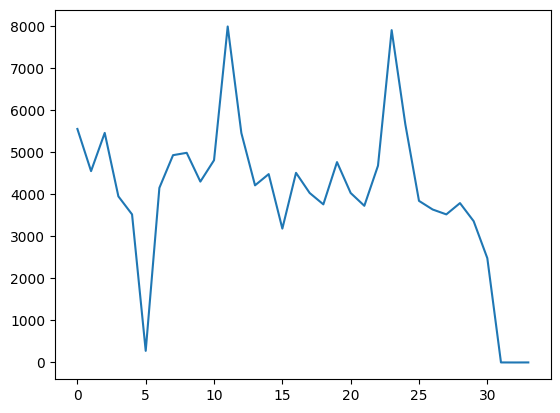

In [26]:
plt.plot(shop_sales_month.shop_id_27)
#plt.plot(shop_sales_month.shop_id_41)
#plt.plot(shop_sales_month.shop_id_42)
#plt.plot(shop_sales_month.shop_id_43)
#plt.plot(shop_sales_month.shop_id_44)
#plt.plot(shop_sales_month.shop_id_45)
#plt.plot(shop_sales_month.shop_id_46)

(1.0, 35.0)

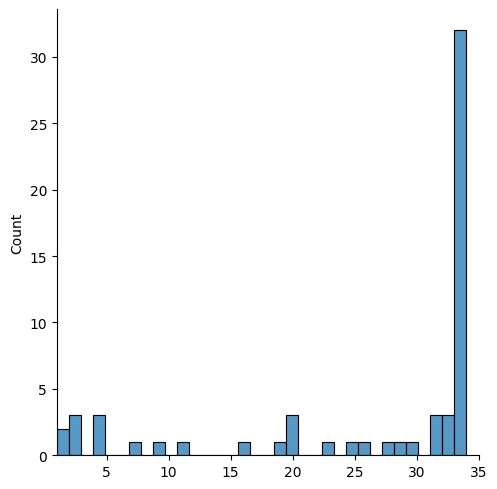

In [27]:
sns.displot(total_month_dict, bins=34)
plt.xlim(1, 35, )

In [28]:
total_month_dict

{'shop_id_0': 2,
 'shop_id_1': 2,
 'shop_id_2': 34,
 'shop_id_3': 34,
 'shop_id_4': 34,
 'shop_id_5': 33,
 'shop_id_6': 34,
 'shop_id_7': 34,
 'shop_id_8': 4,
 'shop_id_9': 4,
 'shop_id_10': 33,
 'shop_id_11': 1,
 'shop_id_12': 34,
 'shop_id_13': 20,
 'shop_id_14': 34,
 'shop_id_15': 34,
 'shop_id_16': 34,
 'shop_id_17': 20,
 'shop_id_18': 34,
 'shop_id_19': 34,
 'shop_id_20': 2,
 'shop_id_21': 34,
 'shop_id_22': 34,
 'shop_id_23': 4,
 'shop_id_24': 34,
 'shop_id_25': 34,
 'shop_id_26': 34,
 'shop_id_27': 32,
 'shop_id_28': 34,
 'shop_id_29': 29,
 'shop_id_30': 26,
 'shop_id_31': 34,
 'shop_id_32': 7,
 'shop_id_33': 9,
 'shop_id_34': 16,
 'shop_id_35': 34,
 'shop_id_36': 1,
 'shop_id_37': 34,
 'shop_id_38': 34,
 'shop_id_39': 20,
 'shop_id_40': 11,
 'shop_id_41': 34,
 'shop_id_42': 34,
 'shop_id_43': 25,
 'shop_id_44': 34,
 'shop_id_45': 34,
 'shop_id_46': 34,
 'shop_id_47': 34,
 'shop_id_48': 19,
 'shop_id_49': 23,
 'shop_id_50': 34,
 'shop_id_51': 33,
 'shop_id_52': 34,
 'shop_id_53'

In [31]:
open_shops

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59])